## The mixed Poisson Problem
We consider the primal form of the Poisson equation:  Find $u$ satisfying

$$
\begin{align}
\nabla^2 u &= -f \quad\text{in $\Omega$} \\
   u &= u_0 \quad\text{on $\Gamma_D$}\\
   \nabla u \cdot n &= g \quad\text{on $\Gamma_N$.}
   \end{align}$$
   
We obtain the dual form by introducing a vector-valued flux $\sigma = \nabla u$.  Substituting, the problem becomes.  Find $(\sigma, u)$ satisfying

$$
\begin{align}
\sigma - \nabla u &= 0 \quad \text{in $\Omega$} \\
\nabla \cdot \sigma &= -f \quad \text{in $\Omega$} \\
u &= u_0 \quad \text{on $\Gamma_D$}\\
\sigma \cdot n &= g \quad\text{on $\Gamma \setminus \Gamma_D =: \Gamma_N$.}
\end{align}
  $$
  
For the variational formulation, we introduce a pair of function spaces, $\Sigma$ and $V$, and seek $(\sigma, u) \in \Sigma \times V$ such that:

$$
\begin{align}
\int_\Omega (\sigma \cdot \tau + \nabla \cdot \tau u)\,\text{d} x &= 
  \int_\Gamma \tau \cdot n u\,\text{d}s \quad \forall \tau \in \Sigma\\ 
\int_\Omega (\nabla\cdot\sigma)v\,\text{d} x &= - \int_\Omega f v\,\text{d}x 
\quad \forall v \in V.
\end{align}
$$

Notice how the weak condition in the primal form turns into a strong condition on the auxiliary variable $\sigma$ and the strong condition on $u$ in the primal form appears as a weak condition on $\sigma$.

For this problem we will solve with homogeneous Dirichlet (strong) conditions $u_0 = 0$ on the boundary of a rectangle domain $\Omega = [0, 2]\times[0,1]$, and will choose $f = 10\exp(-100((x-1)^2 + (y-0.5)^2))$. Later we consider a terrain following mesh.

In [1]:
import matplotlib.pyplot as plt
from firedrake import *

### 1.) Building terrain following mesh

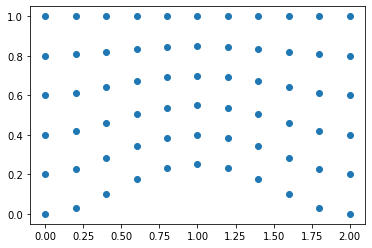

In [2]:
m = IntervalMesh(10,2)
mesh = ExtrudedMesh(m, 5, extrusion_type='uniform')

Vc = mesh.coordinates.function_space()
x, y = SpatialCoordinate(mesh)
f_mesh = Function(Vc).interpolate(as_vector([x, y + ( 0.25 * x**4 -x**3 + x**2) * (1-y) ] ) )
mesh.coordinates.assign(f_mesh)

xs = [mesh.coordinates.dat.data[i][0] for i in range(0,66)]
ys = [mesh.coordinates.dat.data[i][1] for i in range(0,66)]

plt.scatter(xs, ys)


### 2.) Defining $RT_0$ FEM space on extruded mesh

In [3]:
#define RT_0 on extruded meshes

CG_1 = FiniteElement("CG", interval, 1)
DG_0 = FiniteElement("DG", interval, 0)
P1P0 = TensorProductElement(CG_1, DG_0)
RT_horiz = HDivElement(P1P0)
P0P1 = TensorProductElement(DG_0, CG_1)
RT_vert = HDivElement(P0P1)
element = RT_horiz + RT_vert

Sigma = FunctionSpace(mesh, element)
#Sigma = FunctionSpace(mesh, "RTCF", 1)
VD = FunctionSpace(mesh, "DG", 0)

def create_RT_0_element(extr_mesh):
    CG_1 = FiniteElement("CG", interval, 1)
    DG_0 = FiniteElement("DG", interval, 0)
    P1P0 = TensorProductElement(CG_1, DG_0)
    RT_vert = HDivElement(P1P0)
    P0P1 = TensorProductElement(DG_0, CG_1)
    RT_horiz = HDivElement(P0P1)
    element = RT_horiz + RT_vert

    Sigma = FunctionSpace(mesh, element)
    
    return Sigma

### 3.) Define problem (actually Helmholtz eq.) and solve subject to $\sigma \cdot n = 0$ on the whole boundary

## Hybridized Helmholtz equation

(Just Poisson didn't work, the problem semmed to be ill-posed) Now with boundary cnditions $\sigma \cdot n = 0$ everywhere

Find $(\sigma, u, \lambda)$ in $\hat{\Sigma} \times V \times T$ such that 

$$
\begin{align}
\int_\Omega (\sigma \cdot \tau + \nabla \cdot \tau u)\,\text{d} x + \langle [[ \tau ]], \lambda \rangle_{\partial \mathcal{T}_h \setminus \Gamma_D} &= 
  \int_\Gamma \tau \cdot n u\,\text{d}s \quad \forall \tau \in \hat{\Sigma}\\ 
\int_\Omega (\nabla\cdot\sigma)v + v u\,\text{d} x &= - \int_\Omega f v\,\text{d}x 
\quad \forall v \in V\\
\langle \gamma, [[ \sigma ]] \rangle_{\partial \mathcal{T}_h \setminus \Gamma_D} &= \langle \gamma, g \rangle_{\Gamma_N}\quad \forall \gamma \in T
\end{align}
$$

With $g = 0$ on the whole boundary we obtain 

In [5]:
Sigmahat = FunctionSpace(mesh, BrokenElement(Sigma.ufl_element()))
V = FunctionSpace(mesh, VD.ufl_element())
T = FunctionSpace(mesh, FiniteElement("HDiv Trace", mesh.ufl_cell(), degree = 0))
W_hybrid = Sigmahat * V * T

n = FacetNormal(mesh)
sigmahat, uhat, lambdar = TrialFunctions(W_hybrid)
tauhat, vhat, gammar = TestFunctions(W_hybrid)

f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))

wh = Function(W_hybrid)

a_hybrid = ( inner(sigmahat, tauhat)*dx + div(tauhat)*uhat*dx + div(sigmahat)*vhat*dx +vhat*uhat*dx
            + inner(tauhat, n)*lambdar*( ds_b + ds_t + ds_v)
            + inner(sigmahat, n)*gammar* (ds_b + ds_t+ ds_v) 
            + jump(tauhat, n=n)*lambdar('+')*(dS_h + dS_v)
            + jump(sigmahat, n=n)*gammar('+')* (dS_h + dS_v)) 
                                                                   
L = -f*vhat*dx

scpc_parameters = {"ksp_type":"preonly", "pc_type":"lu"}

solve(a_hybrid == L, wh, solver_parameters = {"ksp_type": "gmres","mat_type":"matfree", 
                                              "pc_type":"python", "pc_python_type":"firedrake.SCPC", 
                                              "condensed_field":scpc_parameters, 
                                              "pc_sc_eliminate_fields":"0,1"})





In [ ]:
sigmah, uh, lamdah = wh.split()

file2 = File("PiolaSCPC.pvd")
file2.write(sigmah, uh)

fig, axes = plt.subplots()

quiver(sigmah, axes=axes)
axes.set_aspect("equal")
axes.set_title("$\sigma$")